<p style="text-align:center">
    <img src="https://media.defense.gov/2020/Sep/15/2002497589/1200/1200/0/200915-F-CS000-001.JPG" width="600" height="200"/>
</p>

# Introduction

Suicide is a complex and sensitive topic that refers to the intentional act of taking one's own life. It is a significant public health concern worldwide, with profound social, psychological, and emotional implications. Factors contributing to suicidal behavior are multifaceted, including mental health disorders, social isolation, economic hardships, and personal crises. The impact of suicide extends beyond individuals, affecting families, communities, and societies at large. Efforts to address and prevent suicide involve a comprehensive approach, encompassing mental health awareness, support systems, and the reduction of stigma associated with seeking help. Promoting open dialogue, empathy, and accessible mental health resources are crucial components of suicide prevention initiatives.

In this notebook, an analysis of global suicide rates is conducted, considering various parameters such as country, year, sex, age, population, human development index, GDP by country, GDP per capita, and generation. The dataset used for this analysis is ["Suicide Rates Overview 1985 to 2016"](https://www.kaggle.com/datasets/russellyates88/suicide-rates-overview-1985-to-2016). The exploration aims to provide insights into the patterns and trends associated with suicide rates across different regions and demographic factors.

# Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
import scipy.optimize as opt
import scipy.stats as stats 
import geopandas as gpd
%matplotlib inline
from scipy.stats import chi2_contingency
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm 
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

In [2]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# Readind and Understanding Data

In [3]:
data = pd.read_csv('master.csv')
data.head()

country  year     sex          age  suicides_no  population  \
0  Albania  1987    male  15-24 years           21      312900   
1  Albania  1987    male  35-54 years           16      308000   
2  Albania  1987  female  15-24 years           14      289700   
3  Albania  1987    male    75+ years            1       21800   
4  Albania  1987    male  25-34 years            9      274300   

   suicides/100k pop country-year  HDI for year  gdp_for_year ($)   \
0               6.71  Albania1987           NaN      2,156,624,900   
1               5.19  Albania1987           NaN      2,156,624,900   
2               4.83  Albania1987           NaN      2,156,624,900   
3               4.59  Albania1987           NaN      2,156,624,900   
4               3.28  Albania1987           NaN      2,156,624,900   

   gdp_per_capita ($)       generation  
0                 796     Generation X  
1                 796           Silent  
2                 796     Generation X  
3                 796  G.I. Generation  
4                 796          Boomers

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27820 entries, 0 to 27819
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   country             27820 non-null  object 
 1   year                27820 non-null  int64  
 2   sex                 27820 non-null  object 
 3   age                 27820 non-null  object 
 4   suicides_no         27820 non-null  int64  
 5   population          27820 non-null  int64  
 6   suicides/100k pop   27820 non-null  float64
 7   country-year        27820 non-null  object 
 8   HDI for year        8364 non-null   float64
 9    gdp_for_year ($)   27820 non-null  object 
 10  gdp_per_capita ($)  27820 non-null  int64  
 11  generation          27820 non-null  object 
dtypes: float64(2), int64(4), object(6)
memory usage: 2.5+ MB


In this dataset, a significant number of instances lack human development index data.
To obtain those missing data, the ["Human Development Index (HDI)"](https://www.kaggle.com/datasets/gustavofc/human-development-index-hdi) dataset was used, and subsequently, the two datasets were merged.

In [5]:
HDI_data = pd.read_csv('HDI.csv', encoding='latin-1')
HDI_data.head()

Coverage  HDI Rank      Country   1990   1991   1992   1993   1994   1995  \
0  Country     169.0  Afghanistan  0.302  0.307  0.316  0.312  0.307  0.331   
1  Country      69.0      Albania  0.650  0.631  0.615  0.618  0.624  0.637   
2  Country      91.0      Algeria  0.572  0.576  0.582  0.586  0.590  0.595   
3  Country      36.0      Andorra    NaN    NaN    NaN    NaN    NaN    NaN   
4  Country     148.0       Angola    NaN    NaN    NaN    NaN    NaN    NaN   

    1996  ...   2010   2011   2012   2013   2014   2015   2016   2017   2018  \
0  0.335  ...  0.472  0.477  0.489  0.496  0.500  0.500  0.502  0.506  0.509   
1  0.646  ...  0.745  0.764  0.775  0.782  0.787  0.788  0.788  0.790  0.792   
2  0.602  ...  0.721  0.728  0.728  0.729  0.736  0.740  0.743  0.745  0.746   
3    NaN  ...  0.837  0.836  0.858  0.856  0.863  0.862  0.866  0.863  0.867   
4    NaN  ...  0.517  0.533  0.544  0.555  0.565  0.572  0.578  0.582  0.582   

    2019  
0  0.511  
1  0.795  
2  0.748  
3  0.868  
4  0.581  

[5 rows x 33 columns]

In [6]:
HDI_list = []

for index, row in HDI_data.iterrows():
    country = row['Country']
    for year in HDI_data.columns[3:]:
        hdi_value = row[year]
        HDI_list.append([f"{country}{year}", hdi_value])

In [7]:
clean_data = data.copy()

def locate_sublist(lst, target):
    for sublist in lst:
        if sublist[0] == target:
            return sublist[1]
    return None

for index, row in clean_data.iterrows():
    if pd.isna(row['HDI for year']):
        replacement_value = locate_sublist(HDI_list, row['country-year'])
        if replacement_value is not None:
            clean_data.at[index, 'HDI for year'] = replacement_value

clean_data.head()

country  year     sex          age  suicides_no  population  \
0  Albania  1987    male  15-24 years           21      312900   
1  Albania  1987    male  35-54 years           16      308000   
2  Albania  1987  female  15-24 years           14      289700   
3  Albania  1987    male    75+ years            1       21800   
4  Albania  1987    male  25-34 years            9      274300   

   suicides/100k pop country-year  HDI for year  gdp_for_year ($)   \
0               6.71  Albania1987           NaN      2,156,624,900   
1               5.19  Albania1987           NaN      2,156,624,900   
2               4.83  Albania1987           NaN      2,156,624,900   
3               4.59  Albania1987           NaN      2,156,624,900   
4               3.28  Albania1987           NaN      2,156,624,900   

   gdp_per_capita ($)       generation  
0                 796     Generation X  
1                 796           Silent  
2                 796     Generation X  
3                 796  G.I. Generation  
4                 796          Boomers

In [8]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27820 entries, 0 to 27819
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   country             27820 non-null  object 
 1   year                27820 non-null  int64  
 2   sex                 27820 non-null  object 
 3   age                 27820 non-null  object 
 4   suicides_no         27820 non-null  int64  
 5   population          27820 non-null  int64  
 6   suicides/100k pop   27820 non-null  float64
 7   country-year        27820 non-null  object 
 8   HDI for year        22626 non-null  float64
 9    gdp_for_year ($)   27820 non-null  object 
 10  gdp_per_capita ($)  27820 non-null  int64  
 11  generation          27820 non-null  object 
dtypes: float64(2), int64(4), object(6)
memory usage: 2.5+ MB


# Data Wrangling

In [9]:
grouped_HDI = clean_data.groupby(['country', 'year'])['HDI for year'].mean().reset_index(name='HDI')
grouped_HDI.head()

country  year    HDI
0  Albania  1987    NaN
1  Albania  1988    NaN
2  Albania  1989    NaN
3  Albania  1992  0.615
4  Albania  1993  0.618

In [10]:
countries_with_all_nan = grouped_HDI.groupby('country')['HDI'].apply(lambda x: x.isna().all()).loc[lambda x: x].index
countries_with_nan = grouped_HDI.loc[grouped_HDI['HDI'].isna(), 'country'].unique()
countries_with_nan = sorted(set(countries_with_nan) - set(countries_with_all_nan))
print('Countries where all the values are null,')
print(countries_with_all_nan)
print('')
print('Countries where some of the values are null,')
print(countries_with_nan)

Countries where all the values are null,
Index(['Aruba', 'Dominica', 'Macau', 'Puerto Rico', 'Republic of Korea',
       'Saint Kitts and Nevis', 'San Marino'],
      dtype='object', name='country')

Countries where some of the values are null,
['Albania', 'Antigua and Barbuda', 'Argentina', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Brazil', 'Bulgaria', 'Canada', 'Chile', 'Colombia', 'Costa Rica', 'Czech Republic', 'Ecuador', 'Finland', 'France', 'Georgia', 'Greece', 'Grenada', 'Guatemala', 'Guyana', 'Iceland', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Kiribati', 'Kuwait', 'Luxembourg', 'Malta', 'Mauritius', 'Mexico', 'Montenegro', 'Netherlands', 'New Zealand', 'Norway', 'Panama', 'Paraguay', 'Portugal', 'Romania', 'Russian Federation', 'Saint Lucia', 'Saint Vincent and Grenadines', 'Seychelles', 'Singapore', 'Spain', 'Sri Lanka', 'Suriname', 'Sweden', 'Thailand', 'Trinidad and Tobago', 'Turkmenistan', 'Ukraine', '

In [11]:
years_with_nan = grouped_HDI.loc[grouped_HDI['HDI'].isna(), 'year'].unique()
print('Years where some of the values are null,')
print(years_with_nan)

Years where some of the values are null,
[1987 1988 1989 1985 1986 1990 1991 1992 1993 1994 1995 1998 1999 2000
 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 1996 1997 2015
 2016 2012 2013 2014]


In [12]:
HDI_year = clean_data.groupby('year')[['HDI for year']].mean()
HDI_year.T

year              1985  1986  1987  1988  1989      1990     1991      1992  \
HDI for year  0.699162   NaN   NaN   NaN   NaN  0.716176  0.72546  0.729412   

year           1993      1994  ...      2007      2008      2009      2010  \
HDI for year  0.733  0.741315  ...  0.798613  0.804025  0.802169  0.793718   

year              2011      2012      2013    2014      2015      2016  
HDI for year  0.793819  0.804443  0.808231  0.8085  0.835155  0.842667  

[1 rows x 32 columns]

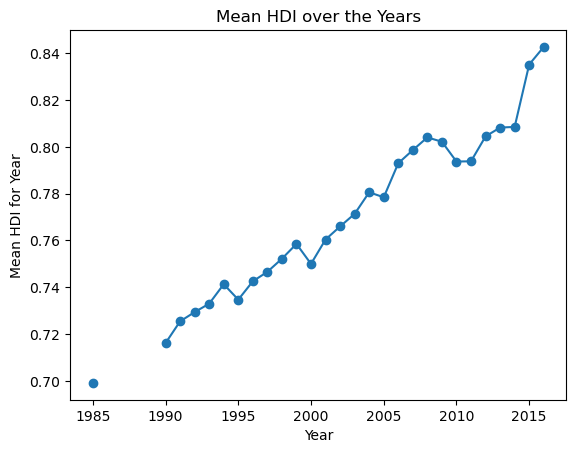

In [13]:
plt.plot(HDI_year.index, HDI_year.values, marker='o')
plt.xlabel('Year')
plt.ylabel('Mean HDI for Year')
plt.title('Mean HDI over the Years')
plt.show()

Some countries lack HDI values in certain years, while others have missing HDI values for every year. Specifically, between 1986 and 1990, all HDI values are missing. To address this, the missing data for countries with partial HDI values are filled through interpolation. Subsequently, for countries missing all HDI values, the gaps are filled by taking the mean of HDI values from other countries for each respective year.

In [14]:
clean_data['HDI for year'] = clean_data.groupby('country')['HDI for year'].transform(lambda group: group.interpolate(method='linear', limit_direction='both'))
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27820 entries, 0 to 27819
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   country             27820 non-null  object 
 1   year                27820 non-null  int64  
 2   sex                 27820 non-null  object 
 3   age                 27820 non-null  object 
 4   suicides_no         27820 non-null  int64  
 5   population          27820 non-null  int64  
 6   suicides/100k pop   27820 non-null  float64
 7   country-year        27820 non-null  object 
 8   HDI for year        26812 non-null  float64
 9    gdp_for_year ($)   27820 non-null  object 
 10  gdp_per_capita ($)  27820 non-null  int64  
 11  generation          27820 non-null  object 
dtypes: float64(2), int64(4), object(6)
memory usage: 2.5+ MB


In [15]:
clean_data['HDI for year'] = clean_data.groupby('year')['HDI for year'].transform(lambda group: group.fillna(group.mean()))
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27820 entries, 0 to 27819
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   country             27820 non-null  object 
 1   year                27820 non-null  int64  
 2   sex                 27820 non-null  object 
 3   age                 27820 non-null  object 
 4   suicides_no         27820 non-null  int64  
 5   population          27820 non-null  int64  
 6   suicides/100k pop   27820 non-null  float64
 7   country-year        27820 non-null  object 
 8   HDI for year        27820 non-null  float64
 9    gdp_for_year ($)   27820 non-null  object 
 10  gdp_per_capita ($)  27820 non-null  int64  
 11  generation          27820 non-null  object 
dtypes: float64(2), int64(4), object(6)
memory usage: 2.5+ MB


In [16]:
HDI_year2 = clean_data.groupby('year')[['HDI for year']].mean()
HDI_year2.T

year              1985      1986      1987      1988     1989      1990  \
HDI for year  0.706244  0.703275  0.711946  0.720556  0.71903  0.709016   

year              1991      1992     1993      1994  ...     2007      2008  \
HDI for year  0.715429  0.718936  0.72465  0.730966  ...  0.79651  0.801789   

year              2009      2010      2011      2012      2013    2014  \
HDI for year  0.800186  0.793718  0.793819  0.804443  0.808231  0.8085   

year              2015      2016  
HDI for year  0.833817  0.844375  

[1 rows x 32 columns]

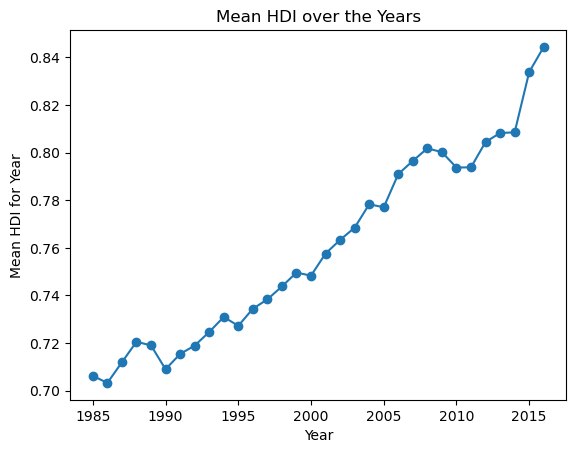

In [17]:
plt.plot(HDI_year2.index, HDI_year2.values, marker='o')
plt.xlabel('Year')
plt.ylabel('Mean HDI for Year')
plt.title('Mean HDI over the Years')
plt.show()

In [18]:
clean_data.head()

country  year     sex          age  suicides_no  population  \
0  Albania  1987    male  15-24 years           21      312900   
1  Albania  1987    male  35-54 years           16      308000   
2  Albania  1987  female  15-24 years           14      289700   
3  Albania  1987    male    75+ years            1       21800   
4  Albania  1987    male  25-34 years            9      274300   

   suicides/100k pop country-year  HDI for year  gdp_for_year ($)   \
0               6.71  Albania1987         0.615      2,156,624,900   
1               5.19  Albania1987         0.615      2,156,624,900   
2               4.83  Albania1987         0.615      2,156,624,900   
3               4.59  Albania1987         0.615      2,156,624,900   
4               3.28  Albania1987         0.615      2,156,624,900   

   gdp_per_capita ($)       generation  
0                 796     Generation X  
1                 796           Silent  
2                 796     Generation X  
3                 796  G.I. Generation  
4                 796          Boomers

In [19]:
duplicate = clean_data[clean_data.duplicated()]
duplicate

Empty DataFrame
Columns: [country, year, sex, age, suicides_no, population, suicides/100k pop, country-year, HDI for year,  gdp_for_year ($) , gdp_per_capita ($), generation]
Index: []

There are no duplicate instances in this dataset.

In [20]:
clean_data.rename(columns={' gdp_for_year ($) ': 'gdp_for_year ($)'}, inplace=True)
clean_data['gdp_for_year ($)'] = clean_data['gdp_for_year ($)'].str.replace(',', '').astype('int64')
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27820 entries, 0 to 27819
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   country             27820 non-null  object 
 1   year                27820 non-null  int64  
 2   sex                 27820 non-null  object 
 3   age                 27820 non-null  object 
 4   suicides_no         27820 non-null  int64  
 5   population          27820 non-null  int64  
 6   suicides/100k pop   27820 non-null  float64
 7   country-year        27820 non-null  object 
 8   HDI for year        27820 non-null  float64
 9   gdp_for_year ($)    27820 non-null  int64  
 10  gdp_per_capita ($)  27820 non-null  int64  
 11  generation          27820 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.5+ MB


In [21]:
clean_data.describe()

year   suicides_no    population  suicides/100k pop  \
count  27820.000000  27820.000000  2.782000e+04       27820.000000   
mean    2001.258375    242.574407  1.844794e+06          12.816097   
std        8.469055    902.047917  3.911779e+06          18.961511   
min     1985.000000      0.000000  2.780000e+02           0.000000   
25%     1995.000000      3.000000  9.749850e+04           0.920000   
50%     2002.000000     25.000000  4.301500e+05           5.990000   
75%     2008.000000    131.000000  1.486143e+06          16.620000   
max     2016.000000  22338.000000  4.380521e+07         224.970000   

       HDI for year  gdp_for_year ($)  gdp_per_capita ($)  
count  27820.000000      2.782000e+04        27820.000000  
mean       0.762215      4.455810e+11        16866.464414  
std        0.093111      1.453610e+12        18887.576472  
min        0.483000      4.691962e+07          251.000000  
25%        0.692000      8.985353e+09         3447.000000  
50%        0.764000      4.811469e+10         9372.000000  
75%        0.837000      2.602024e+11        24874.000000  
max        0.947000      1.812071e+13       126352.000000

# Exploratory Data Analysis

In [22]:
numeric_data = clean_data.select_dtypes(include='number')
print('Correlation values with number of suisides')
numeric_data.corr()['suicides_no'].sort_values(ascending=False)

Correlation values with number of suisides


suicides_no           1.000000
population            0.616162
gdp_for_year ($)      0.430096
suicides/100k pop     0.306604
HDI for year          0.103958
gdp_per_capita ($)    0.061330
year                 -0.004546
Name: suicides_no, dtype: float64

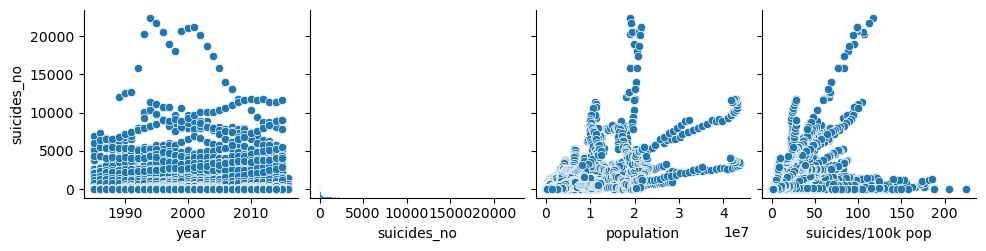

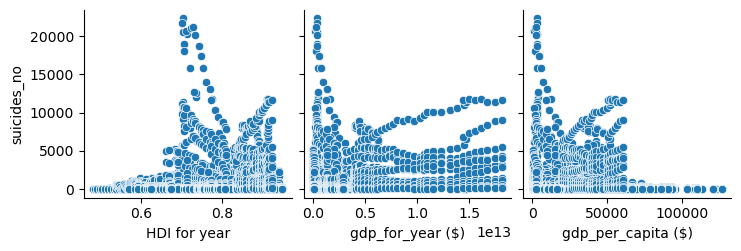

In [23]:
for i in range(0, len(numeric_data.columns), 4):
    sns.pairplot(data=numeric_data,
                x_vars=numeric_data.columns[i:i+4],
                y_vars=['suicides_no'])

Meaningful insights from the above plots cannot be obtained as the data remains somewhat messy.

## The Data Based on Age and Generation

In [24]:
age_generation_data = clean_data.groupby(['age', 'generation']).apply(lambda group: np.average(group['suicides/100k pop'], weights=group['population'])).reset_index(name='suicides_per_100k')
age_generation_data

age       generation  suicides_per_100k
0   15-24 years     Generation X           9.569452
1   15-24 years       Millenials           9.159392
2   25-34 years          Boomers          13.562757
3   25-34 years     Generation X          13.714674
4   25-34 years       Millenials          11.752328
5   35-54 years          Boomers          18.260828
6   35-54 years     Generation X          14.510316
7   35-54 years           Silent          15.618337
8    5-14 years     Generation X           0.489730
9    5-14 years     Generation Z           0.635287
10   5-14 years       Millenials           0.652460
11  55-74 years          Boomers          15.675442
12  55-74 years  G.I. Generation          19.334690
13  55-74 years           Silent          19.750288
14    75+ years  G.I. Generation          28.779787
15    75+ years           Silent          21.764461

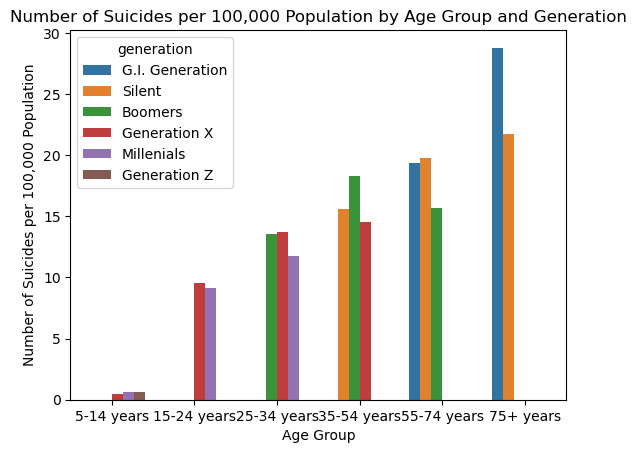

In [25]:
age_order = ['5-14 years', '15-24 years', '25-34 years', '35-54 years', '55-74 years', '75+ years']
generation_order = ['G.I. Generation', 'Silent', 'Boomers', 'Generation X', 'Millenials', 'Generation Z']
sns.barplot(x='age', y='suicides_per_100k', hue='generation', data=age_generation_data, order=age_order, hue_order=generation_order)
plt.title('Number of Suicides per 100,000 Population by Age Group and Generation')
plt.xlabel('Age Group')
plt.ylabel('Number of Suicides per 100,000 Population')
plt.show()

The observation indicates that as age increases and generations grow older, suicide rates tend to rise.

## The Data Based on Country and Year

In [26]:
columns_to_drop = ['sex', 'age', 'suicides/100k pop', 'country-year','generation']
new_data = clean_data.drop(columns_to_drop, axis=1)
agg_dict = {'suicides_no': 'sum',
            'population': 'sum',
            'HDI for year': 'mean',
            'gdp_for_year ($)': 'mean',
            'gdp_per_capita ($)': 'mean'}
new_data = new_data.groupby(['country','year']).agg(agg_dict).reset_index()
new_data['suicides/100k pop'] = new_data['suicides_no']/new_data['population'] * 100000
new_data['suicides/100k pop'] = new_data['suicides/100k pop'].round(3)
new_data.head()

country  year  suicides_no  population  HDI for year  gdp_for_year ($)  \
0  Albania  1987           73     2709600         0.615      2.156625e+09   
1  Albania  1988           63     2764300         0.615      2.126000e+09   
2  Albania  1989           68     2803100         0.615      2.335125e+09   
3  Albania  1992           47     2822500         0.615      7.094526e+08   
4  Albania  1993           73     2807300         0.618      1.228071e+09   

   gdp_per_capita ($)  suicides/100k pop  
0               796.0              2.694  
1               769.0              2.279  
2               833.0              2.426  
3               251.0              1.665  
4               437.0              2.600

### The Top 10 Countries With the Highest Number of Suicides.

In [27]:
suicides = new_data.pivot(index='country', columns='year', values='suicides_no')
suicides['Total'] = suicides.sum(axis=1)
suicides.head()

year                   1985    1986    1987    1988    1989    1990    1991  \
country                                                                       
Albania                 NaN     NaN    73.0    63.0    68.0     NaN     NaN   
Antigua and Barbuda     0.0     0.0     0.0     0.0     0.0     1.0     0.0   
Argentina            1988.0  2284.0  2286.0  2354.0  2247.0  2140.0  1951.0   
Armenia                 NaN     NaN     NaN     NaN     NaN    93.0    80.0   
Aruba                   NaN     NaN     NaN     NaN     NaN     NaN     NaN   

year                   1992    1993    1994  ...    2008    2009    2010  \
country                                      ...                           
Albania                47.0    73.0    50.0  ...   160.0     0.0    96.0   
Antigua and Barbuda     0.0     1.0     0.0  ...     0.0     0.0     NaN   
Argentina            2184.0  2230.0  2241.0  ...  3059.0  2884.0  2943.0   
Armenia                83.0   106.0   112.0  ...    63.0    53.0    73.0   
Aruba                   NaN     NaN     NaN  ...     4.0     4.0     7.0   

year                   2011    2012    2013    2014    2015  2016    Total  
country                                                                     
Albania                 NaN     NaN     NaN     NaN     NaN   NaN   1970.0  
Antigua and Barbuda     NaN     0.0     0.0     0.0     1.0   NaN     11.0  
Argentina            2912.0  3248.0  2987.0  3231.0  3073.0   NaN  82219.0  
Armenia                67.0    79.0    67.0    58.0    74.0  67.0   1905.0  
Aruba                   9.0     NaN     NaN     NaN     NaN   NaN    101.0  

[5 rows x 33 columns]

In [28]:
years = list(range(1985, 2016))
suicides.sort_values(['Total'], ascending=False, axis=0, inplace=True)
suicides.head(10)

year                   1985     1986     1987     1988     1989     1990  \
country                                                                    
Russian Federation      NaN      NaN      NaN      NaN  37921.0  39028.0   
United States       29446.0  30892.0  30783.0  30388.0  30218.0  30895.0   
Japan               23257.0  25484.0  23663.0  22676.0  21013.0  20002.0   
France              12501.0  12529.0  12161.0  11599.0  11715.0  11403.0   
Ukraine                 NaN      NaN  10050.0   9751.0  10887.0  10645.0   
Germany                 NaN      NaN      NaN      NaN      NaN  13924.0   
Republic of Korea    3689.0   3458.0   3301.0   2949.0   3023.0   3159.0   
Brazil               4228.0   4271.0   4672.0   4466.0   4463.0   4803.0   
Poland                  NaN      NaN      NaN      NaN      NaN   4970.0   
United Kingdom       5105.0   4839.0   4594.0   4971.0   4361.0   4643.0   

year                   1991     1992     1993     1994  ...     2008     2009  \
country                                                 ...                     
Russian Federation  39281.0  45923.0  55846.0  61420.0  ...  38211.0  37408.0   
United States       30790.0  30471.0  31084.0  31123.0  ...  36030.0  36900.0   
Japan               19780.0  20756.0  20353.0  20744.0  ...  30073.0  30523.0   
France              11502.0  11644.0  12251.0  12041.0  ...  10353.0  10499.0   
Ukraine             10700.0  11666.0  12469.0  13826.0  ...   9454.0   9715.0   
Germany             14010.0  13458.0  12690.0  12718.0  ...   9459.0   9579.0   
Republic of Korea    3069.0   3533.0   4124.0   4212.0  ...  12858.0  15402.0   
Brazil               5156.0   5207.0   5508.0   5896.0  ...   9184.0   9346.0   
Poland               5316.0   5713.0   5624.0   5519.0  ...   5682.0   6477.0   
United Kingdom       4547.0   4628.0   4462.0   4380.0  ...   4259.0   4246.0   

year                   2010     2011     2012     2013     2014     2015  \
country                                                                    
Russian Federation  33356.0  31038.0  29643.0  28690.0  26541.0  25432.0   
United States       38362.0  39508.0  40596.0  41143.0  42769.0  44189.0   
Japan               29411.0  28766.0  26338.0  25991.0  24357.0  23092.0   
France              10379.0  10408.0   9743.0   9600.0   8881.0      NaN   
Ukraine              9089.0   8973.0   9058.0      NaN   7968.0   7574.0   
Germany             10030.0  10153.0   9896.0  10091.0  10217.0  10088.0   
Republic of Korea   15558.0  15906.0  14159.0  14426.0  13834.0  13510.0   
Brazil               9429.0   9822.0  10295.0  10513.0  10631.0  11163.0   
Poland               6357.0   6113.0   6368.0   6218.0   5934.0   5420.0   
United Kingdom       4188.0   4393.0   4444.0   4824.0   4788.0   4910.0   

year                2016      Total  
country                              
Russian Federation   NaN  1209742.0  
United States        NaN  1034013.0  
Japan                NaN   806902.0  
France               NaN   329127.0  
Ukraine              NaN   319950.0  
Germany              NaN   291262.0  
Republic of Korea    NaN   261730.0  
Brazil               NaN   226613.0  
Poland               NaN   139098.0  
United Kingdom       NaN   136805.0  

[10 rows x 33 columns]

In [29]:
suicides_top10 = suicides.head(10)
suicides_top10 = suicides_top10[years].transpose()
suicides_top10.head()

country  Russian Federation  United States    Japan   France  Ukraine  \
year                                                                    
1985                    NaN        29446.0  23257.0  12501.0      NaN   
1986                    NaN        30892.0  25484.0  12529.0      NaN   
1987                    NaN        30783.0  23663.0  12161.0  10050.0   
1988                    NaN        30388.0  22676.0  11599.0   9751.0   
1989                37921.0        30218.0  21013.0  11715.0  10887.0   

country  Germany  Republic of Korea  Brazil  Poland  United Kingdom  
year                                                                 
1985         NaN             3689.0  4228.0     NaN          5105.0  
1986         NaN             3458.0  4271.0     NaN          4839.0  
1987         NaN             3301.0  4672.0     NaN          4594.0  
1988         NaN             2949.0  4466.0     NaN          4971.0  
1989         NaN             3023.0  4463.0     NaN          4361.0

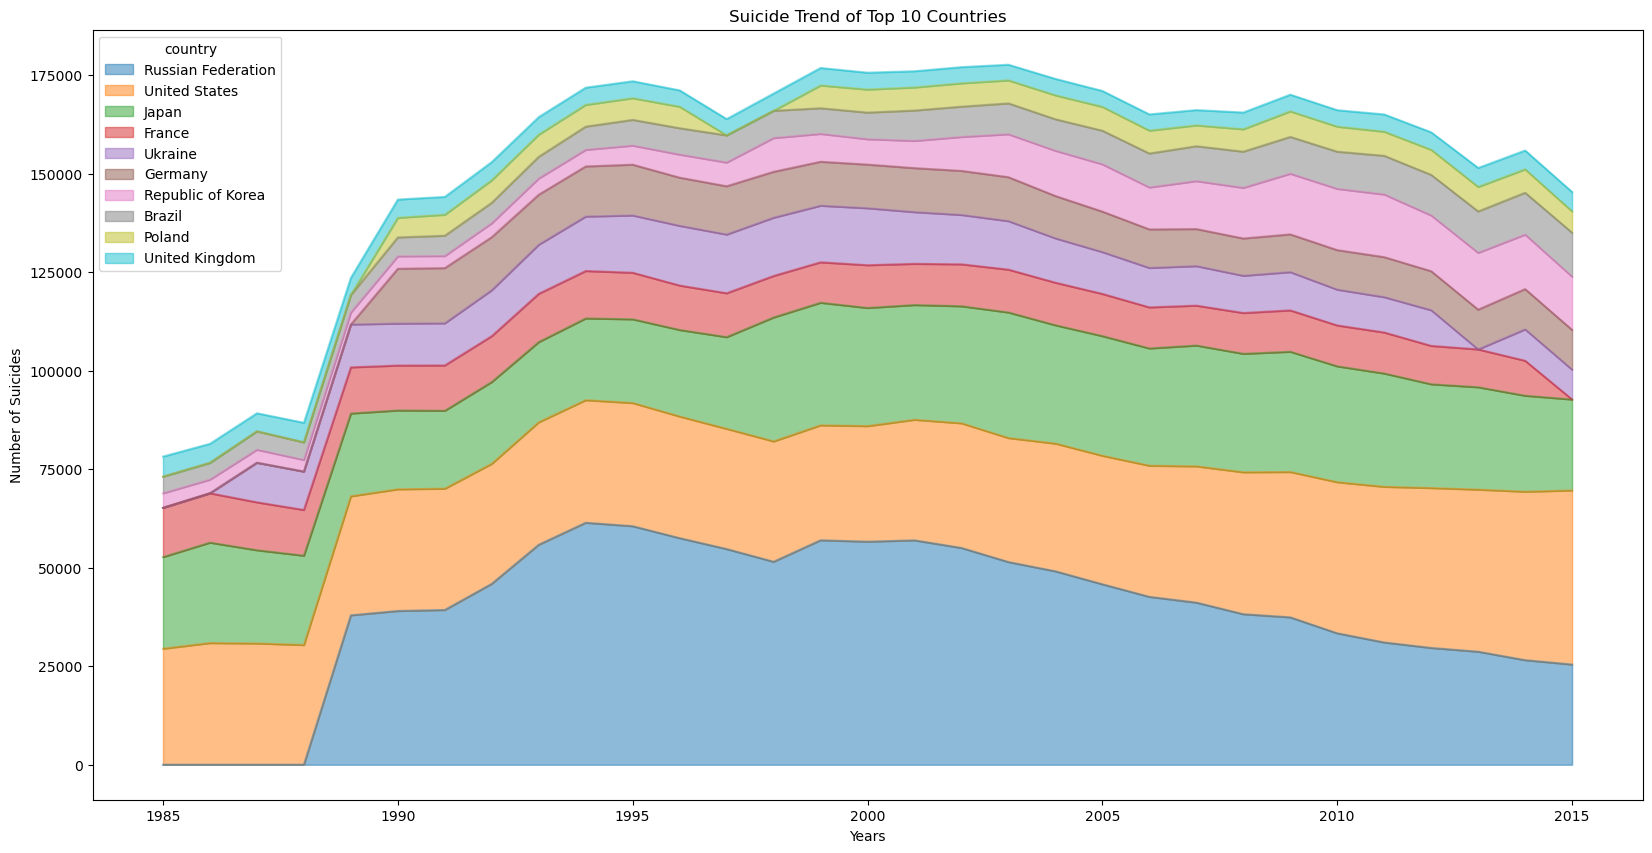

In [30]:
suicides_top10.plot(kind='area',
                     stacked=True,
                     alpha=0.5,
                     figsize=(20, 10))

plt.title('Suicide Trend of Top 10 Countries')
plt.ylabel('Number of Suicides')
plt.xlabel('Years')

plt.show()

### Correlation Within Number of Suicides and Other Data

In [31]:
new_numeric_data = new_data.select_dtypes(include='number')
print('Correlation values with number of suicides')
new_numeric_data.corr()['suicides_no'].sort_values(ascending=False)

Correlation values with number of suicides


suicides_no           1.000000
population            0.808095
gdp_for_year ($)      0.657589
suicides/100k pop     0.360253
HDI for year          0.158756
gdp_per_capita ($)    0.093461
year                 -0.007759
Name: suicides_no, dtype: float64

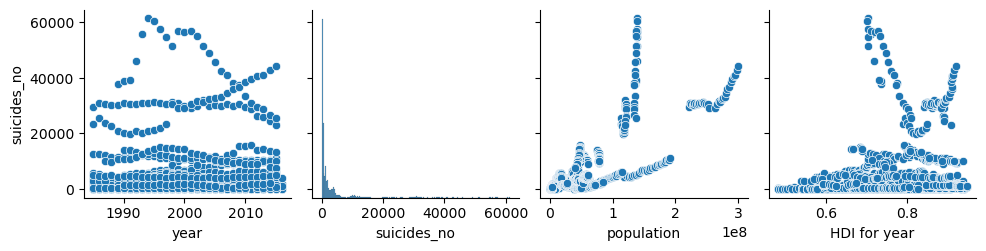

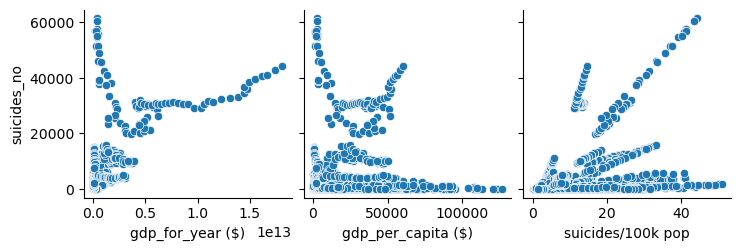

In [32]:
for i in range(0, len(new_numeric_data.columns), 4):
    sns.pairplot(data=new_numeric_data,
                x_vars=new_numeric_data.columns[i:i+4],
                y_vars=['suicides_no'])

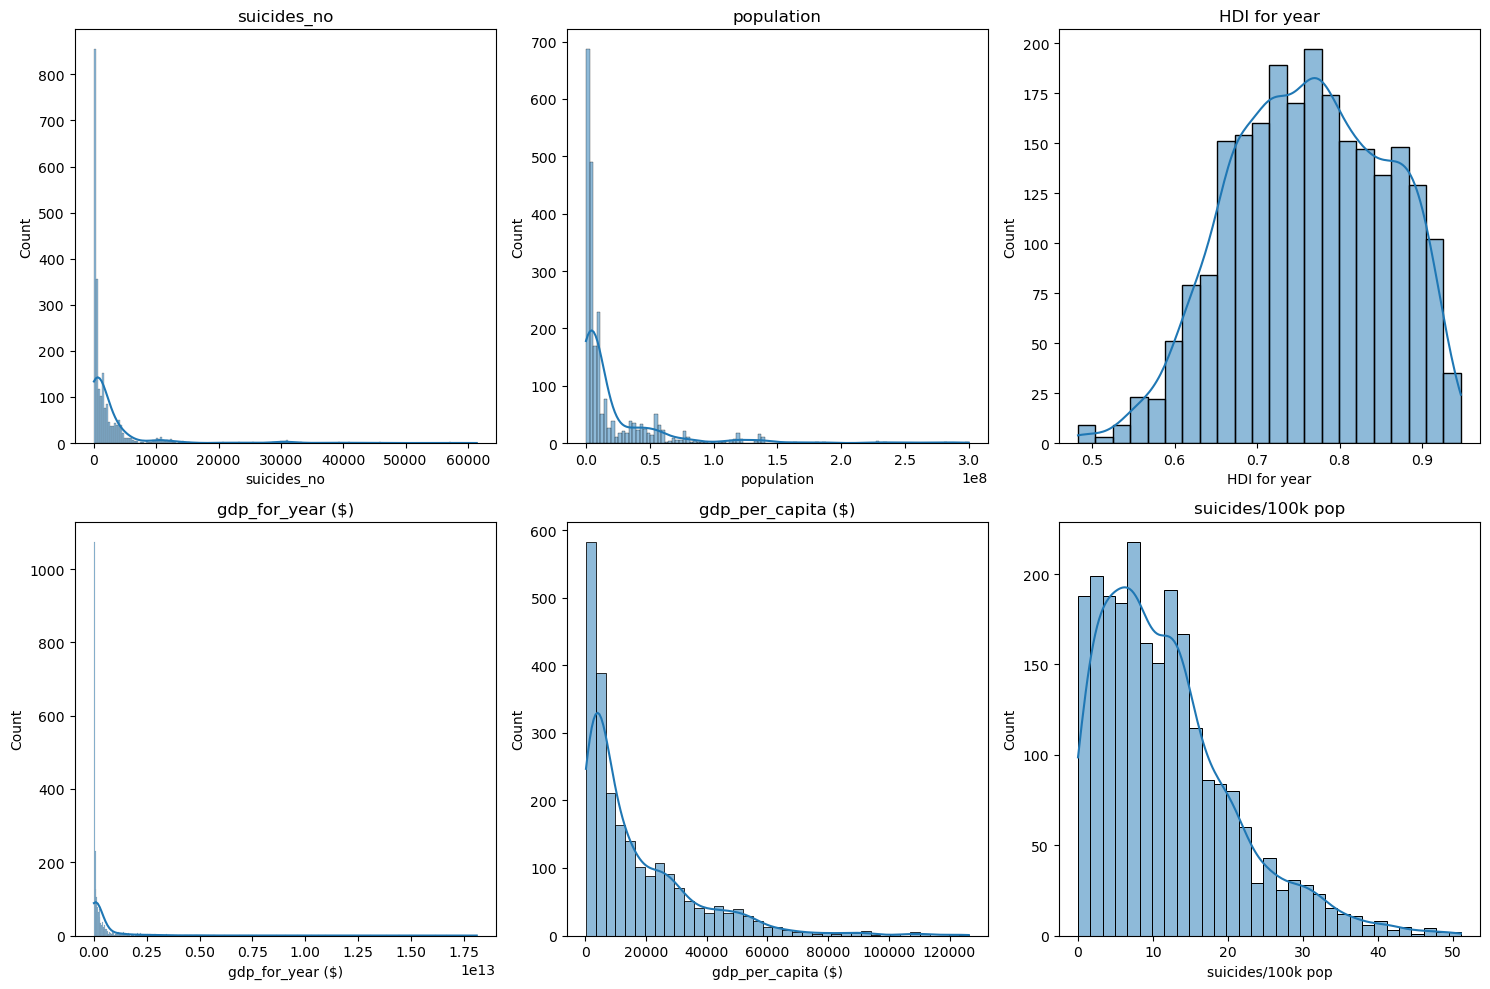

In [33]:
fig, ax_ = plt.subplots(2, 3, figsize=(15, 10))

for i, column in enumerate(new_data.columns[2:]):
    row = i // 3
    col = i % 3
    sns.histplot(new_data[column], ax=ax_[row, col], kde=True)
    ax_[row, col].set_title(column)

plt.tight_layout()
plt.show()

Let's apply a log transformation to the data to explore whether a more meaningful relationship can be observed between the number of suicides and other variables.

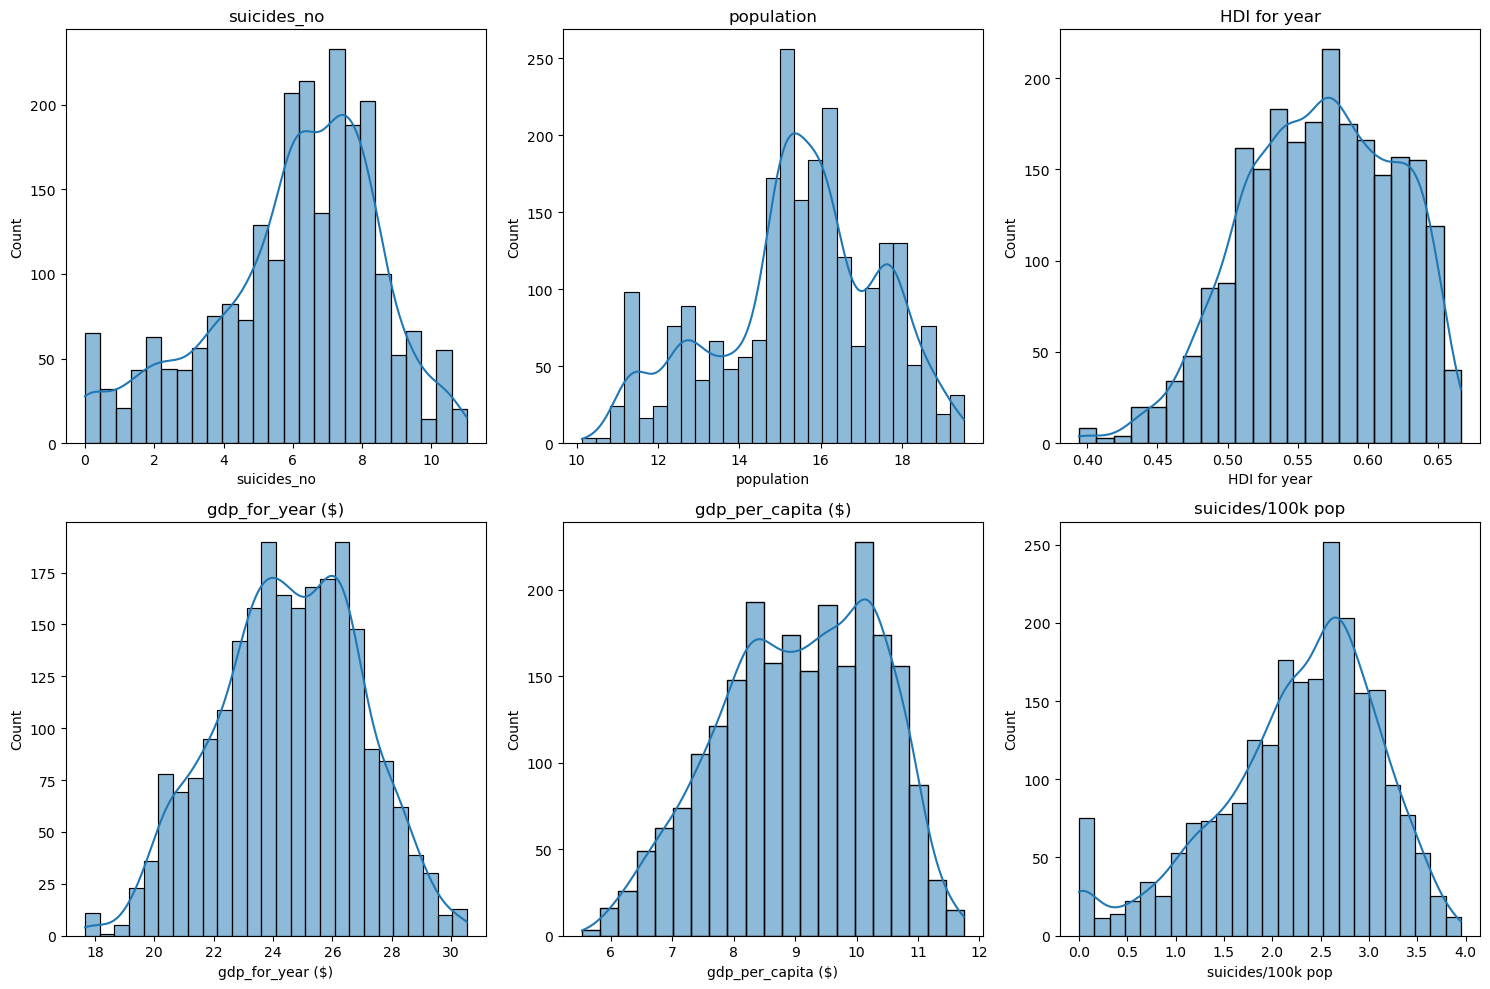

In [34]:
new_data_2 = new_data.copy()
new_data_2[new_data_2.columns[2:]] = new_data_2[new_data_2.columns[2:]].apply(np.log1p)

fig, ax_ = plt.subplots(2, 3, figsize=(15, 10))

for i, column in enumerate(new_data_2.columns[2:]):
    row = i // 3
    col = i % 3
    sns.histplot(new_data_2[column], ax=ax_[row, col], kde=True)
    ax_[row, col].set_title(column)

plt.tight_layout()
plt.show()

In [35]:
new_numeric_data_2 = new_data_2.select_dtypes(include='number')
print('Correlation values with number of suisides')
new_numeric_data_2.corr()['suicides_no'].sort_values(ascending=False)

Correlation values with number of suisides


suicides_no           1.000000
population            0.911711
gdp_for_year ($)      0.810219
suicides/100k pop     0.652453
HDI for year          0.237824
gdp_per_capita ($)    0.116504
year                  0.013242
Name: suicides_no, dtype: float64

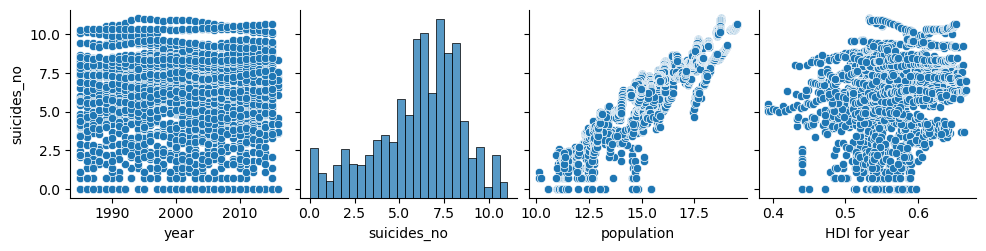

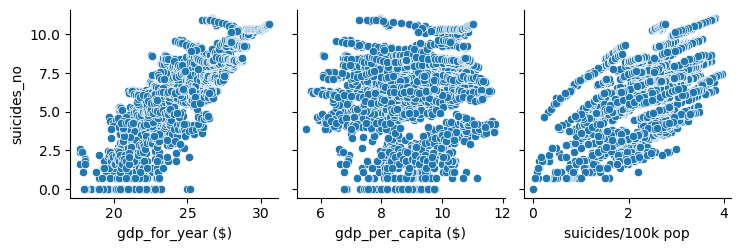

In [36]:
for i in range(0, len(new_numeric_data_2.columns), 4):
    sns.pairplot(data=new_numeric_data_2,
                x_vars=new_numeric_data_2.columns[i:i+4],
                y_vars=['suicides_no'])

As anticipated, population exhibits a strong relationship with the number of suicides. Additionally, GDP by countries also shows a noticeable correlation with the number of suicides.

### Number of Suicides by Country on Map

In [37]:
world = gpd.read_file('countries.geojson')

In [38]:
country_data = clean_data.groupby('country')['suicides_no'].sum().reset_index()
country_data.head()

country  suicides_no
0              Albania         1970
1  Antigua and Barbuda           11
2            Argentina        82219
3              Armenia         1905
4                Aruba          101

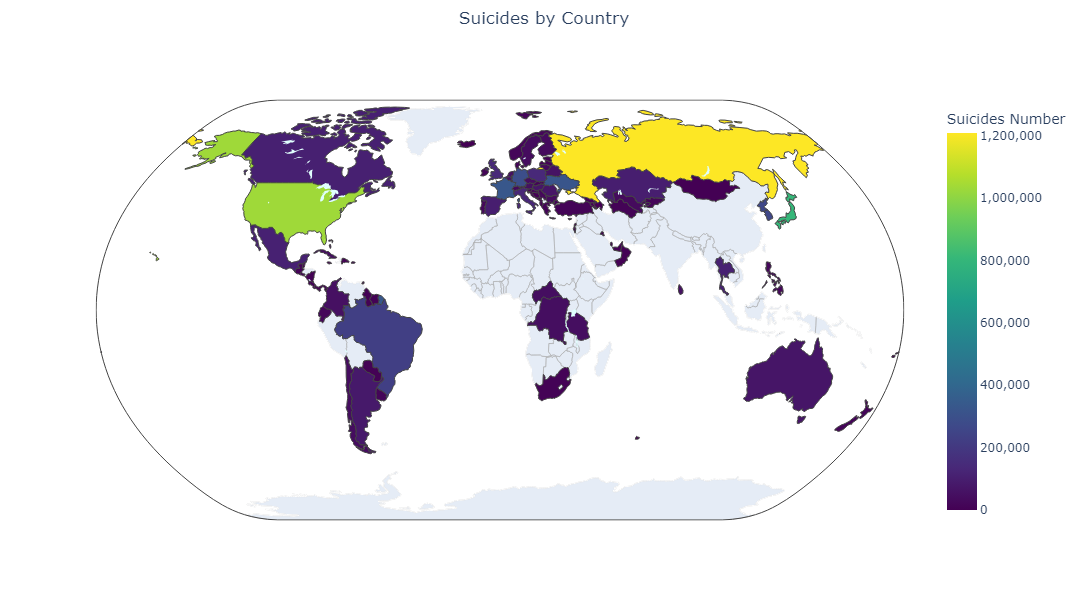

In [39]:
def find_best_match(country_name, country_list):
    match, score, _ = process.extractOne(country_name, country_list)
    return match, score

world['ADMIN'] = world['ADMIN'].str.strip()
country_data['country'] = country_data['country'].str.strip()

matches = {}

for index, row in world.iterrows():
    country_name = row['ADMIN']
    match, score = find_best_match(country_name, country_data['country'])

    if score >= 80:
        matches[country_name] = match

world['matched_country'] = world['ADMIN'].map(matches)

merged_df = pd.merge(world, country_data, left_on='matched_country', right_on='country', how='left')

fig = px.choropleth(merged_df,
                    locations='ISO_A3',
                    color='suicides_no',
                    hover_name='ADMIN',
                    color_continuous_scale='Viridis',
                    projection='natural earth',
                    title='Suicides by Country')

fig.update_geos(
    showcountries=True,
    countrycolor="darkgrey",
    countrywidth=0.5,
    showcoastlines=True,
    coastlinecolor="white",
    coastlinewidth=1,
)

fig.update_layout(
    geo=dict(
        bgcolor='rgba(0,0,0,0)',
        lakecolor='#e0fffe',
    ),
    coloraxis_colorbar=dict(
        title='Suicides Number',
        tickprefix='',
        ticksuffix='',
        exponentformat='none',
        showticksuffix='last',
    ),
    title=dict(
        x=0.5,
        y=0.98,
        xanchor='center',
        yanchor='top',
    ),
)

fig.update_layout(width=1100, height=600)
fig.show()

## Hypothesis Testing

### Comparison of the Number of Suicides Between Males and Females

$ 𝐻_{0}:\mu_{1} \leq \mu_{2} $ The average number of suicides among males is less than or equal to females. \
$ 𝐻_{A}:\mu_{1} > \mu_{2} $ The average number of suicides among males is greater than that among females.

In [40]:
male = clean_data.loc[data['sex'] == 'male']
male_suicides = male['suicides/100k pop']
print('The mean number of suicides among males per 100,000 population is', male_suicides.mean())
female = clean_data.loc[data['sex'] == 'female']
female_suicides = female['suicides/100k pop']
print('The mean number of suicides among females per 100,000 population is', female_suicides.mean())

The mean number of suicides among males per 100,000 population is 20.23932854061826
The mean number of suicides among females per 100,000 population is 5.392866283249461


[Text(0.5, 1.0, 'Suicides per 100,000 Population vs Sex')]

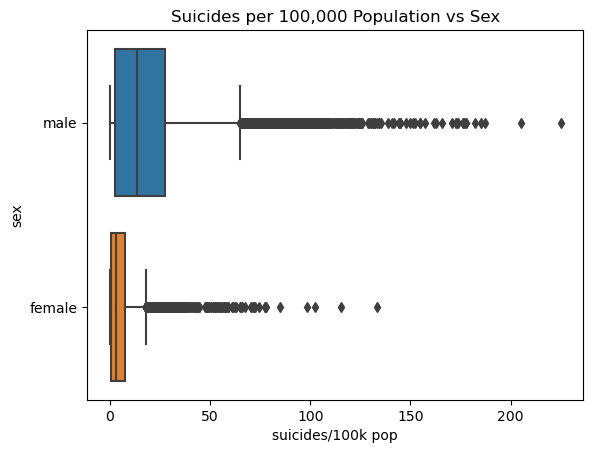

In [41]:
sns.boxplot(x=clean_data['suicides/100k pop'] , y=clean_data['sex'], data=clean_data).set(title="Suicides per 100,000 Population vs Sex")

In [42]:
t_val, p_value = stats.ttest_ind(male_suicides, female_suicides)
p_value_onetail = p_value/2
print("t_value = {} , p_value ={} , p_value_onetail = {}".format(t_val, p_value, p_value_onetail))

t_value = 70.96074900327741 , p_value =0.0 , p_value_onetail = 0.0


The null hypothesis can be rejected at 5% confidence interval. The average number of suicides among males is greater than that among females.

### Comparison of the Number of Suicides Among Three Generations: 'Silent,' 'Boomers,' and 'Generation X.'

$ 𝐻_{0}:\mu_{1}=\mu_{2}=\mu_{3} $ The mean number of suicides is the same across the three generations ('Silent,' 'Boomers,' and 'Generation X'). \
$ 𝐻_{A}: $ At least one of the means for the number of suicides among the three generations is different.

In [43]:
clean_data.groupby('generation')['suicides_no'].sum()

generation
Boomers            2284498
G.I. Generation     510009
Generation X       1532804
Generation Z         15906
Millenials          623459
Silent             1781744
Name: suicides_no, dtype: int64

In [44]:
generation_data = clean_data.loc[clean_data['generation'].isin(['Silent', 'Boomers', 'Generation X'])]
generation_data.rename(columns={'suicides/100k pop': 'suicides_per_100k'}, inplace=True)
generation_data.groupby('generation')['suicides_per_100k'].mean()

generation
Boomers         14.742094
Generation X    10.556874
Silent          18.418848
Name: suicides_per_100k, dtype: float64

<Axes: xlabel='suicides_per_100k', ylabel='generation'>

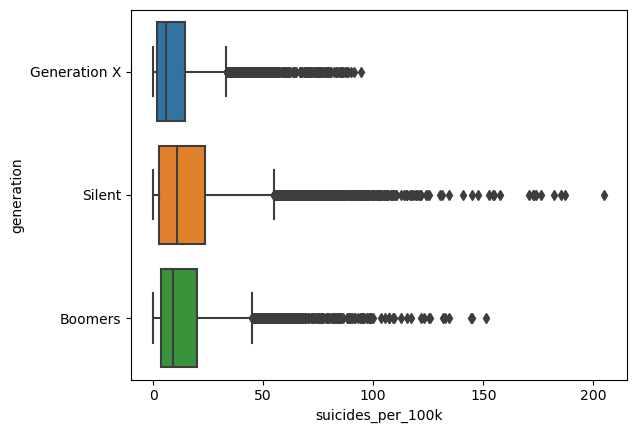

In [45]:
sns.boxplot(x='suicides_per_100k', y='generation', data=generation_data)

In [46]:
formula = 'suicides_per_100k ~ C(generation)'
model = ols(formula, generation_data).fit()
aov_table = anova_lm(model)
print(aov_table)

                    df        sum_sq       mean_sq          F         PR(>F)
C(generation)      2.0  1.976163e+05  98808.148444  288.88251  3.447828e-124
Residual       17759.0  6.074213e+06    342.035758        NaN            NaN


The null hypothesis can be rejected at 5% confidence interval. At least one of the means for the number of suicides among the three generations is different.

### Examining Significance: Differences in Proportion of Number of Suicides Based on Sex Across Various Generations

$ 𝐻_{0} $: The proportions of suicides based on sex are not significantly different across various generations. \
$ 𝐻_{A} $: The proportions of suicides based on sex are different across various generations.

In [47]:
contingency = pd.crosstab(clean_data['sex'], clean_data['generation'], values=clean_data['suicides/100k pop'], aggfunc='sum')
contingency

generation   Boomers  G.I. Generation  Generation X  Generation Z  Millenials  \
sex                                                                             
female      14518.25         15062.12      13641.90        391.36     7372.04   
male        59044.80         50646.74      54006.55        552.82    24089.70   

generation    Silent  
sex                   
female      24029.10  
male        93188.45

<Axes: xlabel='generation'>

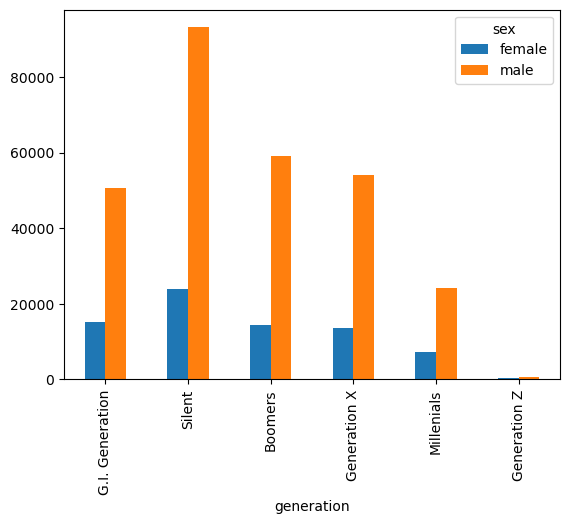

In [48]:
generation_order = ['G.I. Generation', 'Silent', 'Boomers', 'Generation X', 'Millenials', 'Generation Z']
contingency = contingency[generation_order]
contingency = contingency.T
contingency.plot(kind='bar')

In [49]:
chi2, p_val, dof, exp_freq = chi2_contingency(contingency, correction = False)
print('chi-square statistic: {} , p_value: {} , degree of freedom: {} ,expected frequencies: {} '.format(chi2, p_val, dof, exp_freq))

chi-square statistic: 612.2949705690623 , p_value: 4.458845898560916e-130 , degree of freedom: 5 ,expected frequencies: [[13824.76600384 51884.09399616]
 [24661.89795856 92555.65204144]
 [15477.24238069 58085.80761931]
 [14232.84457792 53415.60542208]
 [ 6619.36904055 24842.37095945]
 [  198.65003845   745.52996155]] 


The null hypothesis can be rejected at 5% confidence interval. The proportions of suicides based on sex are different across various generations.